#### Paper Summary 

### LayoutLM: Pre-training of Text and Layout for Document Image Understanding
Source: https://arxiv.org/abs/1912.13318



Based on the Transformer architecture as the backbone, LayoutLM takes
advantage of multimodal inputs, including token embeddings, layout embeddings, and image embeddings.

#### <b> Training objectives:</b>
  1.  Masked visual-language model (MVLM)
  2.  Multi-label document classification

#### Overview

* LayoutLM Jointly model interactions between text and layout information across scanned document images.
* Inspired by the BERT model, where input textual
 information is mainly represented by text embeddings and position
 embeddings
 *  Two types of input embeddings:
    1.   2-D position embedding: denotes the relative position of a token within a document
    2.   Image embedding: for scanned token images within a document.
      * It can capture some appearance features such as font directions, types,
 and colors.
 * Dataset used for model pre-training:
    1. IIT-CDIP Test Collection 1.0 dataset:
      * Contains more than 6 million documents, with more than 11 million
scanned document images
 * Three benchmark
 datasets as the downstream tasks to evaluate the performance of the
 pre-trained LayoutLM model:
    1.   FUNSD dataset:
      * used for spatial layout analysis and form understanding.
    2.  SROIE dataset:
      * for Scanned Receipts Information Extraction.
    3.  RVL-CDIP dataset:
      * for document image classification, which consists of 400,000 grayscale images in 16 classes.

There are two types of features which  substantially improve the language representation in a visually rich document:
1.  Document Layout Information:
  * Embeds relative positions information of words as 2-D position representation.
  * Based on the self-attention mechanism within the Transformer, embedding 2-D position features into the language representation will better align the layout information with the semantic representation.
2.  Visual Information:
  * Typically, documents contain some visual
signals to show the importance and priority of document segments.
  * The visual information can be represented by image features and effectively utilized in document representations.
  * For document-level
  visual features, the whole image can indicate the document layout,
which is an essential feature for document image classification.
  *  For
word-level visual features, styles such as bold, underline, and italic,
are also significant hints for the sequence labeling tasks.
  * Combining the image features with traditional
text representations can bring richer semantic representations to
documents.

#### Model Architecture



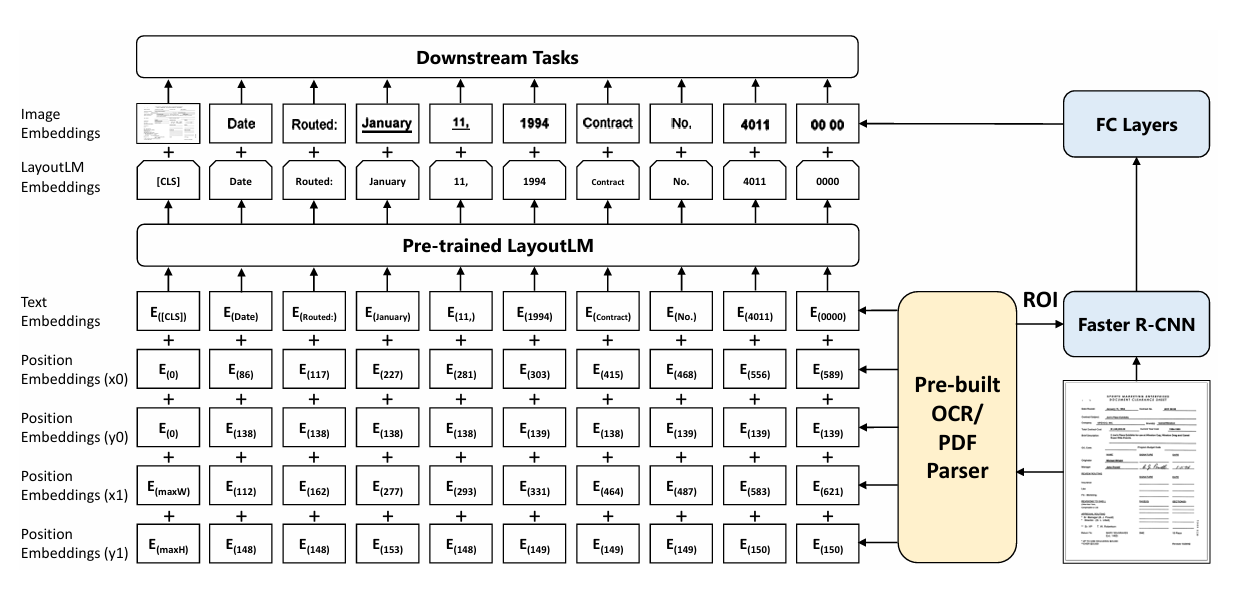

 Figure: An example of LayoutLM where 2-D layout and image embeddings are integrated into the original BERT architecture.The LayoutLM embeddings and image embeddings from Faster R-CNN (uses ResNet-101 as the backbone) work together for down stream tasks.

Uses the BERT architecture as the backbone and add two new input embeddings:
* 2-D position embedding:
  * Unlike the position embedding that
models the word position in a sequence, 2-D position embedding
aims to model the relative spatial position in a document.
  * Considers a document page as a coordinate system with the top left origin.
  * The bounding box can be precisely defined by (x0, y0, x1, y1), where (x0, y0) corresponds to the position of the upper left in the bounding box, and (x1,y1) represents the position of the lower right.
  *  Four position embedding layers with two
embedding tables (Table X & Y), where the embedding layers representing the
same dimension share the same embedding table.

* Image embedding:
  * To utilize the image feature of a document and
align the image feature with the text.
  *  With the bounding box of each word from OCR results, the image will be splitted into several pieces, and they have a one-to-one correspondence with the words.
  * Image region features will be generated with these piece of images from the Faster R-CNN model as the token image embeddings.
  * ResNet-101 model is used as the backbone network in the Faster R-CNN
model, which is pre-trained on the Visual Genome dataset.


#### LayoutLM Pre-training

Model is pre-trained on two tasks.<br>
**Task #1: Masked Visual-Language Model** - bridging the gap between the visual and language modalities
* Inspired by the masked language model
* To learnthe language representation with the clues of 2-D
position embeddings and text embeddings.
* During the pre-training, Some of the **input tokens were masked** randomly but it **keeps the corresponding 2-D position embeddings**, and then the model is trained
to predict the masked tokens given the contexts

**Task #2: Multi-label Document Classification**
* Uses a Multi-label Document Classification (MDC) loss
* Given a set of scanned documents, document tags are used to supervise the pre-training process so that the model can cluster the knowledge from different domains and generate better document-level representation.

**Dataset information:**<br>
* **IIT-CDIP Test Collection 1.0 dataset:**
  * contains more than 6 million documents, with more than 11 million scanned document images.
  * Moreover, each document has its corresponding text and metadata stored in XML files.
  * The text is the content produced by applying OCR to document images.
  * The metadata describes the properties of the document, such as the unique identity and document labels.
  * Although the metadata contains erroneous and inconsistent tags, the scanned document images in this large-scale dataset are perfectly suitable for pre-training the model.
  * Scanned document images are processeed by applying the OCR (using Tesseract) and storing corresponding locaton to obtain the necessary layout information.
  * Considering that the document layout may vary in different page size,actual coordinate are scaled to a “virtual” coordinate: the actual coordinate is scaled to have a value from 0 to 1,000.
  * OCR results are stored in hOCR format which clearly defines the OCR results of one single document image using a hierarchical representation.

**Model Specifications:**<br>
* **BASE model:**
  * 12-layer Transformer with 768 hidden sizes, and 12 attention heads, which contains about 113M parameters.
  *  BERT base model is used to initialize all modules in LayoutLM model except the 2-D position embedding layer.
* **LARGE model:**
  * 24-layer Transformer with 1,024 hidden sizes and 16 attention heads, which is initialized by the pre-trained BERT LARGE model and contains about 343M parameters.
* **Batch size:** 80
* **Optimizer:** Adam
* **learning rate:** Initial 5e-5 and linear decay learning rate schedule

**Token Information:**<br>
  * 15% of the input tokens for prediction.
  * Masked tokens are replaced with the [MASK] token 80% of the time, a random token 10% of the time, and an unchanged token 10% of the time.
  * Then, the model predicts the corresponding token with the **cross-entropy
loss**.

**Resource Information:**<br>
  * trained on 8 NVIDIA Tesla V100 32GB GPUs
  * Time:
    * BASE model: 80 hours to finish one epoch on 11M documents
    * LARGE model: nearly 170 hours to finish one epoch

#### Fine-tuning LayoutLM

Follows the typical finetuning strategy and updates all parameters in an end-to-end way on task-specific datasets. Model is fine-tuned on three document image understanding tasks: <br>
**Task #1  Form understanding task<br>**
  * For extracting and structuring the textual content of forms.
  * Aims to extract key-value pairs from the scanned form images.
  * this task includes two sub-tasks:
    1.  semantic labeling
        * Task of aggregating words as semantic entities and
assigning pre-defined labels to them.
        * Treats semantic labeling as a sequence labeling problem.
        * passes the final representation into a linear layer followed by a softmax layer to predict the label of each token.
        * Model Specifications:
          * Epochs: 100
          * Batch size: 16
          * Learning rate: 5e-5
    2.  semantic linking (Out of the scope of this paper)
        * Task of predicting the relations between semantic entities.
  * LayoutLM predicts {B, I, E, S, O} tags for each token and uses sequential labeling to detect each type of entity in the dataset.

**Task #2  Receipt understanding task**
  * This task requires filling several predefined semantic slots according to the scanned receipt images.
  * Given a set of receipts, need to fill specific slots (i.g., company, address, date, and total).
  * Different from the form understanding task that requires labeling all matched entities and keyvalue pairs, the number of semantic slots is fixed with pre-defined keys. Therefore, the model only needs to predict the corresponding values using the sequence labeling method.
  * LayoutLM predicts {B, I, E, S, O} tags for each token and uses sequential labeling to detect each type of entity in the dataset.

**Task #3  Document image classification task**
  * Aims to predict the corresponding category for each document image.
  * To fine-tune model on this task, the output from the LayoutLM model and the
whole image embedding are concatenated, followed by a softmax layer for category
prediction.
  * Model  Specifications:
   * Epochs: 30
    * Batch size: 40
    * Learning rate: 2e-5
    
  * LayoutLM predicts the class labels using the representation of the [CLS] token

**Dataset Information:**
  * **FUNSD Dataset:**
    * Used to evaluate **form understanding task**
    * Includes 199 real, fully annotated, scanned forms with 9,707
semantic entities and 31,485 words.
    * These forms are organized as a list of semantic entities that are interlinked.
    * Each semantic entity comprises a unique identifier, a label (i.e., question, answer, header, or other), a bounding box, a list of links with other entities, and a list of words.
    * The dataset is split into 149 training samples and 50
testing samples.

  * **SROIE Dataset:**
    * For **receipt information extraction**
    * Contains 626 receipts for training and 347 receipts for testing.
    * Each receipt is organized as a list of text lines with bounding boxes.
    * Each receipt is labeled with four types of entities which are {company, date, address, total}.

  * **RVL-CDIP Dataset:**
    * Consists of 400,000 grayscale images in 16 classes, with 25,000 images per class.
    * There are 320,000 training images, 40,000 validation images, and 40,000 test images.
    * The images are resized, so their largest dimension does not exceed 1,000 pixels.
    * The 16 classes include {letter, form, email, handwritten, advertisement, scientific report, scientific publication, specification, file folder, news article, budget, invoice, presentation, questionnaire, resume, memo}


**Evaluation Metric:**
  * **Form understanding & Receipt understanding task:**
    * F1-score
  * **Document image classification task:**
    * Accuracy Score


#### Results

##### Form Understanding: on FUNSD dataset

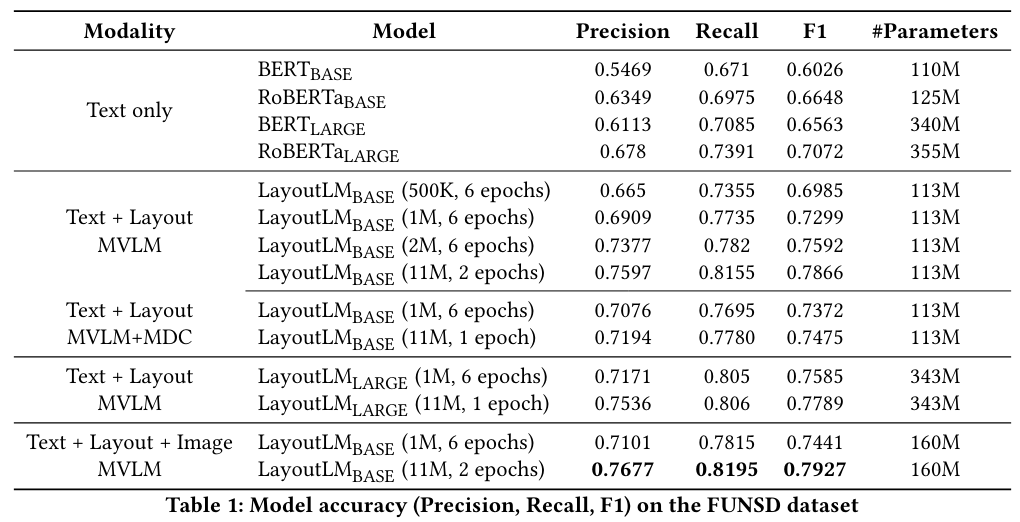

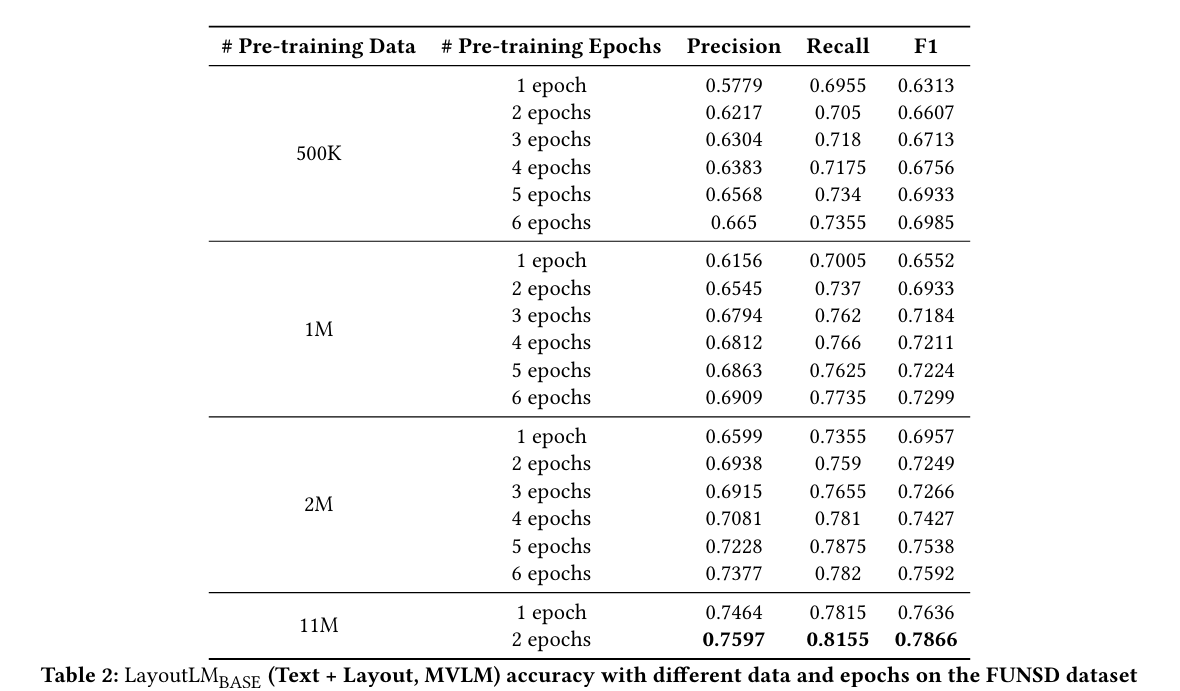

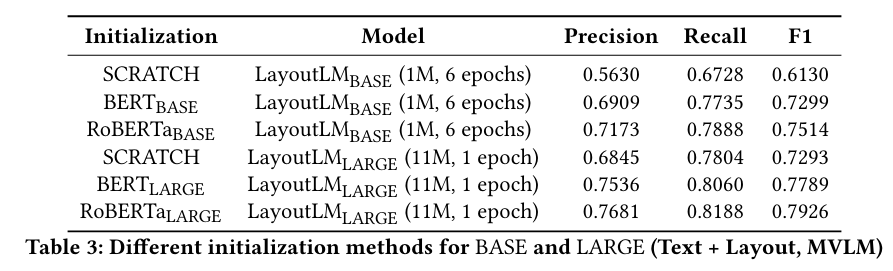

##### Receipt Understanding: on SROIE dataset

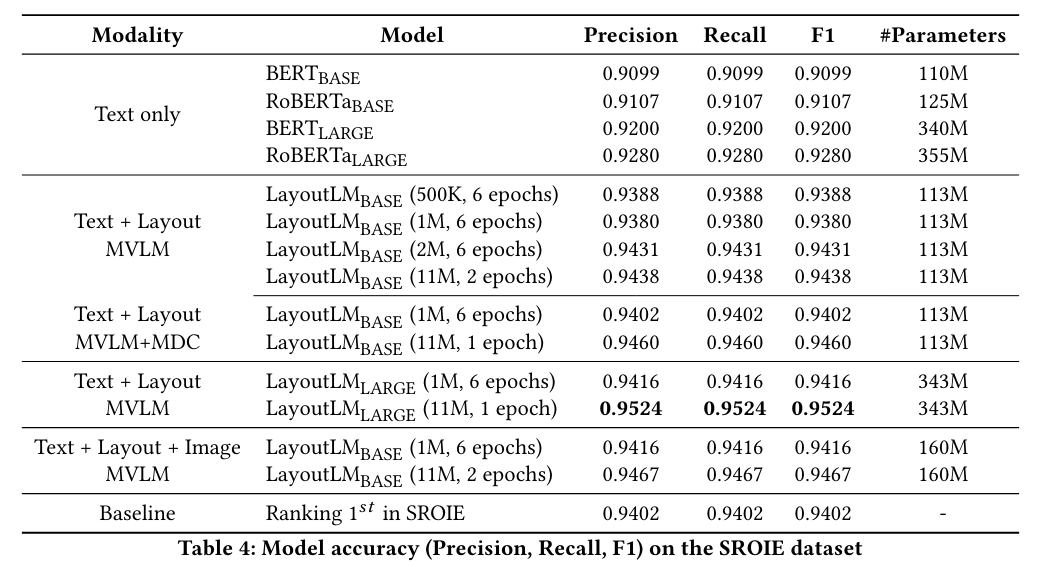

#####  Document Image Classification: on RVL-CDIP dataset

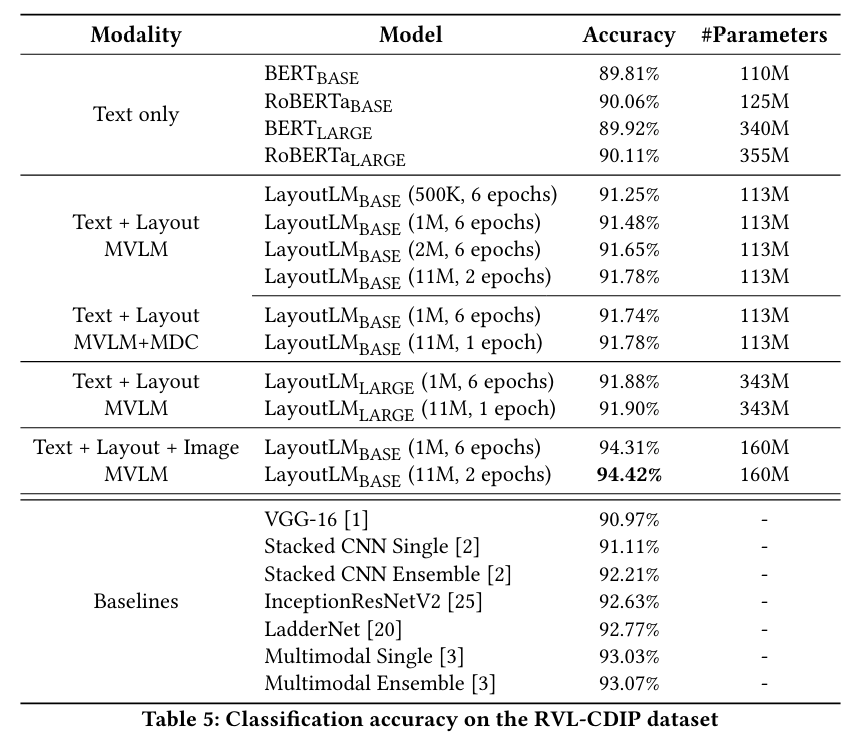